In [1]:
 import os
import nibabel as nib
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import time

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input 
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Activation
# from keras.layers import Conv2D, MaxPooling2D
# from keras.models import Model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.utils.np_utils import to_categorical
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.applications import resnet, inception_resnet_v2, inception_v3, densenet, vgg16, vgg19
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Loading Models

Models for : 

*   Inception
*   VGG
*   AlexNet 
*   Late Merging

In [ ]:
### For now we will develop this code for the models developed for the 100x150x150 dataformat since the whole dataset is only the middle slice for each patient

### Loading Models
###Inception
incep_model = load_model("/content/gdrive/My Drive/Colab Notebooks/TFM/Models/IncepV3.hdf5")

### AlexNet
alex_model = load_model("/content/gdrive/My Drive/Colab Notebooks/TFM/Models/AlexNet.hdf5")


### VGG-16

vgg_model = load_model("/content/gdrive/My Drive/Colab Notebooks/TFM/Models/VGG16.hdf5")

### Late Merging Model

LM_model = load_model("/content/gdrive/My Drive/Colab Notebooks/TFM/Models/Late Merging.hdf5")


In [3]:
X_train = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Long Format/X_train.npy")
X_test = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Long Format/X_test.npy")
y_train_au = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Long Format/y_train.npy")
y_test_au = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Long Format/y_test.npy")

In [6]:
X_ed_train = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Short Format/X_ed.npy")
X_es_train = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Short Format/X_es.npy")
X_ed_test = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Short Format/X_ed_test.npy")
X_es_test = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Short Format/X_es_test.npy")

y_test = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Short Format/y_test.npy")
y_train =  np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Short Format/y_train.npy")

In [7]:
X_ed_train.shape

(100, 150, 150, 3)

In [8]:
### Testing Models

def metricas(y_pred, y_test_tr):
    cm = confusion_matrix(y_test_tr, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10,6))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)

    class_list = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']

    tick_marks = np.arange(len(class_list))
    plt.xticks(tick_marks+0.5, class_list, rotation=45)
    plt.yticks(tick_marks+0.5, class_list, rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(classification_report(y_test_tr,y_pred,target_names=class_list))

2/2 - 0s - loss: 1.3494 - accuracy: 0.5400


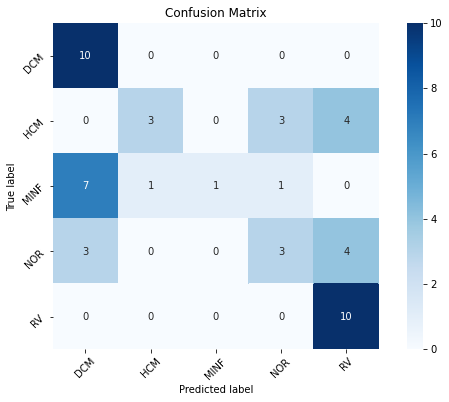

              precision    recall  f1-score   support

         DCM       0.50      1.00      0.67        10
         HCM       0.75      0.30      0.43        10
        MINF       1.00      0.10      0.18        10
         NOR       0.43      0.30      0.35        10
          RV       0.56      1.00      0.71        10

    accuracy                           0.54        50
   macro avg       0.65      0.54      0.47        50
weighted avg       0.65      0.54      0.47        50



In [ ]:
## Testing to check results

LM_model.evaluate([X_ed_test[:,:,:,[0]],
                    X_ed_test[:,:,:,[1]],
                    X_ed_test[:,:,:,[2]]],
                    y_test, verbose = 2)

Y_pred = LM_model.predict([X_ed_test[:,:,:,[0]],
                    X_ed_test[:,:,:,[1]],
                    X_ed_test[:,:,:,[2]]])

y_pred = np.argmax(Y_pred, axis =1)

y_test_tr = np.argmax(y_test, axis=1)

metricas(y_pred, y_test_tr)

2/2 - 0s - loss: 1.1050 - accuracy: 0.5800


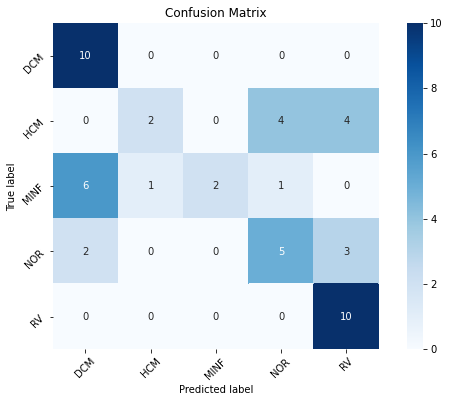

              precision    recall  f1-score   support

         DCM       0.56      1.00      0.71        10
         HCM       0.67      0.20      0.31        10
        MINF       1.00      0.20      0.33        10
         NOR       0.50      0.50      0.50        10
          RV       0.59      1.00      0.74        10

    accuracy                           0.58        50
   macro avg       0.66      0.58      0.52        50
weighted avg       0.66      0.58      0.52        50



In [ ]:
## Testing to check results

LM_model.evaluate([X_es_test[:,:,:,[0]],
                    X_es_test[:,:,:,[1]],
                    X_es_test[:,:,:,[2]]],
                    y_test, verbose = 2)

Y_pred = LM_model.predict([X_es_test[:,:,:,[0]],
                    X_es_test[:,:,:,[1]],
                    X_es_test[:,:,:,[2]]])

y_pred = np.argmax(Y_pred, axis =1)

y_test_tr = np.argmax(y_test, axis=1)

metricas(y_pred, y_test_tr)

19/19 - 1s - loss: 0.5496 - accuracy: 0.7817


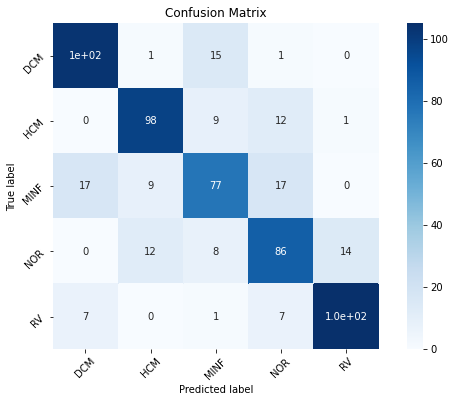

              precision    recall  f1-score   support

         DCM       0.81      0.86      0.83       120
         HCM       0.82      0.82      0.82       120
        MINF       0.70      0.64      0.67       120
         NOR       0.70      0.72      0.71       120
          RV       0.88      0.88      0.88       120

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



In [ ]:
## Testing to check results

## Train

LM_model.evaluate([X_train[:,:,:,[0]],
                    X_train[:,:,:,[1]],
                    X_train[:,:,:,[2]]],
                    y_train_au, verbose = 2)

Y_pred = LM_model.predict([X_train[:,:,:,[0]],
                    X_train[:,:,:,[1]],
                    X_train[:,:,:,[2]]])

y_pred = np.argmax(Y_pred, axis =1)

y_test_tr = np.argmax(y_train_au, axis=1)

metricas(y_pred, y_test_tr)

4/4 - 0s - loss: 0.8450 - accuracy: 0.6600


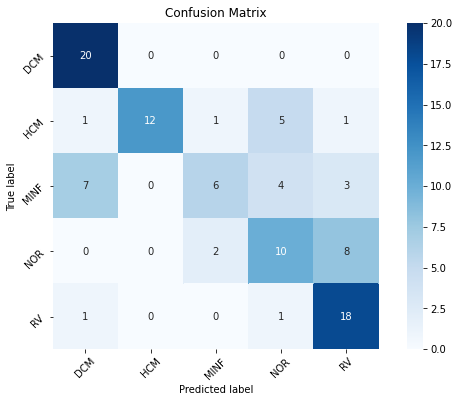

              precision    recall  f1-score   support

         DCM       0.69      1.00      0.82        20
         HCM       1.00      0.60      0.75        20
        MINF       0.67      0.30      0.41        20
         NOR       0.50      0.50      0.50        20
          RV       0.60      0.90      0.72        20

    accuracy                           0.66       100
   macro avg       0.69      0.66      0.64       100
weighted avg       0.69      0.66      0.64       100



In [ ]:
## Testing to check results

## Train

LM_model.evaluate([X_ed_train[:,:,:,[0]],
                    X_ed_train[:,:,:,[1]],
                    X_ed_train[:,:,:,[2]]],
                    y_train, verbose = 2)

Y_pred = LM_model.predict([X_ed_train[:,:,:,[0]],
                    X_ed_train[:,:,:,[1]],
                    X_ed_train[:,:,:,[2]]])

y_pred = np.argmax(Y_pred, axis =1)

y_test_tr = np.argmax(y_train, axis=1)

metricas(y_pred, y_test_tr)



In [9]:
def model_converter(model):
  model_FE = Model(inputs=model.inputs, outputs= model.layers[-2].output)
  return model_FE

In [ ]:
# Incept_FE = Model(inputs=Incept_Model.inputs, outputs=Incept_Model.layers[-2].output)


In [ ]:
# img1 = X_train_es[0]
# img2 = X_train_es[1]

In [ ]:
# img = img1.reshape((1,150,150,3))
# img2 = img2.reshape((1,150,150,3))

In [10]:
def feature_extractor(X, model):
  extract_feats = list()
  for patient in range(X.shape[0]):
    img1 = X[patient]
    img_ = img1.reshape((1,150,150,3))
    FE = model.predict(img_)

    extract_feats.append(FE[0,:])

    output_vector = np.asanyarray(extract_feats)

  return output_vector

Getting the Feature Extraction Models

In [ ]:
Incept_FE = model_converter(incep_model)
AlexNet_FE = model_converter(alex_model)
LM_FE = model_converter(LM_model)

In [ ]:
### InceptionV3
DL_features_train_ES = feature_extractor(X_es_train, Incept_FE)
DL_features_train_ED = feature_extractor(X_ed_train, Incept_FE)

In [ ]:
DL_features_test_ES = feature_extractor(X_es_test, Incept_FE)
DL_features_test_ED = feature_extractor(X_ed_test, Incept_FE)

In [ ]:
DL_features_test_ES.shape

(50, 2048)

In [ ]:
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_IncepModel_train_ES.csv', DL_features_train_ES, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_IncepModel_test_ES.csv', DL_features_test_ES, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_IncepModel_train_ED.csv', DL_features_train_ED, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_IncepModel_test_ED.csv', DL_features_test_ED, delimiter=',')

In [ ]:
##AlexNet Normal
Alex_DL_features_train_ES = feature_extractor(X_es_train, AlexNet_FE)
Alex_DL_features_train_ED = feature_extractor(X_ed_train, AlexNet_FE)

Alex_DL_features_test_ES = feature_extractor(X_es_test, AlexNet_FE)
Alex_DL_features_test_ED = feature_extractor(X_ed_test, AlexNet_FE)

In [ ]:
Alex_DL_features_test_ED.shape

(50, 4096)

In [ ]:
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_AlexNet_train_ES.csv', Alex_DL_features_train_ES, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_AlexNet_test_ES.csv', Alex_DL_features_test_ES, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_AlexNet_train_ED.csv', Alex_DL_features_train_ED, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_AlexNet_test_ED.csv', Alex_DL_features_test_ED, delimiter=',')

In [ ]:
##Extracting features from VGG

VGG_FE = model_converter(VGG_model)

VGG_extracted_train = feature_extractor(X_train_es, VGG_FE)
VGG_extracted_test = feature_extractor(X_test_es, VGG_FE)

In [ ]:
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Models/VGG_Extracted_Features_train.csv', VGG_extracted_train, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Models/VGG_Extracted_Features_test.csv', VGG_extracted_test, delimiter=',')

In [ ]:
##### AlexNet Dilated

AlexDil_DL_features_train_ES = feature_extractor(X_train_es, AlexNet_dil_FE)
AlexDil_DL_features_train_ED = feature_extractor(X_train_ed, AlexNet_dil_FE)

AlexDil_DL_features_test_ES = feature_extractor(X_test_es, AlexNet_dil_FE)
AlexDil_DL_features_test_ED = feature_extractor(X_test_ed, AlexNet_dil_FE)

In [ ]:
AlexDil_DL_features_test_ED.shape

(50, 4096)

In [ ]:
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Models/Extracted_Features_AlexNetDil_train_ES.csv', AlexDil_DL_features_train_ES, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Models/Extracted_Features_AlexNetDil_test_ES.csv', AlexDil_DL_features_test_ES, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Models/Extracted_Features_AlexNetDil_train_ED.csv', AlexDil_DL_features_train_ED, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Models/Extracted_Features_AlexNetDil_test_ED.csv', AlexDil_DL_features_test_ED, delimiter=',')

In [ ]:
def feature_extractor(X, model):
  extract_feats = list()
  for patient in range(X.shape[0]):
    img1 = X[patient]
    img_ = img1.reshape((1,150,150,3))
    FE = model.predict(img_)
    

    extract_feats.append(FE[0,:])

    output_vector = np.asanyarray(extract_feats)

  return output_vector

In [ ]:
X_test_es.shape

(50, 150, 150, 3)

In [ ]:
def feature_extractor_LM(X, model):
  extract_feats = list()
  for patient in range(X.shape[0]):
    
    img1 = X[patient]
    img_ = img1.reshape((1,150,150,3))
    FE = model.predict([img_[:,:,:,[0]],
                      img_[:,:,:,[1]],
                      img_[:,:,:,[2]]])
    
    extract_feats.append(FE[0,:])

  output_vector = np.asanyarray(extract_feats)

  return output_vector
  

In [ ]:
X_ed_test.shape

(50, 150, 150, 3)

In [ ]:
Extracted = feature_extractor_LM(X_train, LM_FE)

In [ ]:
LM_features_train= feature_extractor_LM(X_train, LM_FE)
# LM_features_train_ED = feature_extractor(X_train_es, AlexNet_dil_FE)

LM_features_test_es = feature_extractor_LM(X_es_test, LM_FE)
LM_features_test_ed = feature_extractor_LM(X_ed_test, LM_FE)

In [ ]:
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_LM_features_train.csv', LM_features_train, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_LM_features_test_ES.csv', LM_features_test_es, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_LM_features_test_ED.csv', LM_features_test_ed, delimiter=',')

AlexNet Module

In [11]:
alex_model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/TFM/Models/AlexNet-Long_sgd.hdf5")

In [12]:
alex_model_FE = model_converter(alex_model2)

In [13]:
### InceptionV3
DL_features_train_ES = feature_extractor(X_es_train, alex_model_FE)
DL_features_train_ED = feature_extractor(X_ed_train, alex_model_FE)

In [14]:
DL_features_train_ES.shape

(100, 5)

In [15]:
DL_features_test_ES = feature_extractor(X_es_test, alex_model_FE)
DL_features_test_ED = feature_extractor(X_ed_test, alex_model_FE)

In [16]:
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_AlexModel2_train_ES.csv', DL_features_train_ES, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_AlexModel2_test_ES.csv', DL_features_test_ES, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_AlexModel2_train_ED.csv', DL_features_train_ED, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/TFM/Extracted DLR/DLR_AlexModel2_test_ED.csv', DL_features_test_ED, delimiter=',')